In [1]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━

In [2]:
from catboost import CatBoostRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import warnings
from xgboost import XGBRegressor
 
# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")
warnings.filterwarnings("ignore", category=Warning, module="LightGBM")

# Import Data
Join training data & test data in the all data

In [3]:
train = pd.read_csv('/kaggle/input/car-price-prediction-x/train.csv')
test = pd.read_csv('/kaggle/input/car-price-prediction-x/test.csv')
train['IsTrain'] = 1
test['IsTrain'] = 0
all_data = pd.concat([train, test.drop('Id', axis=1)], axis=0)
all_data.head()

,model,year,motor_type,running,wheel,color,type,status,motor_volume,price,IsTrain
0,toyota,2022,petrol,3000 km,left,skyblue,sedan,excellent,2.0,24500.0,1
1,mercedes-benz,2014,petrol,132000 km,left,black,sedan,excellent,2.0,25500.0,1
2,kia,2018,petrol,95000 miles,left,other,sedan,excellent,2.0,11700.0,1
3,mercedes-benz,2002,petrol,137000 miles,left,golden,sedan,excellent,3.2,12000.0,1
4,mercedes-benz,2017,petrol,130000 km,left,black,sedan,good,2.0,26000.0,1


# Data Exploration

In [4]:
all_data.describe()

,year,motor_volume,price,IsTrain
count,2053.000000,2053.000000,1642.000000,2053.000000
mean,2014.837311,2.033025,15982.633374,0.799805
std,6.576572,0.248348,7176.084647,0.400244
min,1987.000000,0.200000,462.000000,0.000000
25%,2013.000000,2.000000,12000.000000,1.000000
50%,2017.000000,2.000000,15750.000000,1.000000
75%,2019.000000,2.000000,18500.000000,1.000000
max,2023.000000,4.300000,87000.000000,1.000000


In [5]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2053 entries, 0 to 410
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         2053 non-null   object 
 1   year          2053 non-null   int64  
 2   motor_type    2053 non-null   object 
 3   running       2053 non-null   object 
 4   wheel         2053 non-null   object 
 5   color         2053 non-null   object 
 6   type          2053 non-null   object 
 7   status        2053 non-null   object 
 8   motor_volume  2053 non-null   float64
 9   price         1642 non-null   float64
 10  IsTrain       2053 non-null   int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 192.5+ KB


## Does the model impact the price?

In [6]:
all_data['model'].unique()

array(['toyota', 'mercedes-benz', 'kia', 'nissan', 'hyundai'],
      dtype=object)

<Axes: xlabel='model', ylabel='price'>

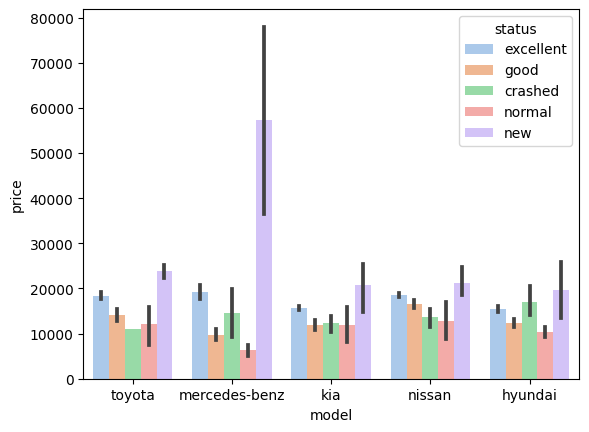

In [7]:
sns.barplot(train,x='model', y='price', hue='status', palette='pastel')

There's some outliers in the data regarding the car models

<Axes: xlabel='model', ylabel='price'>

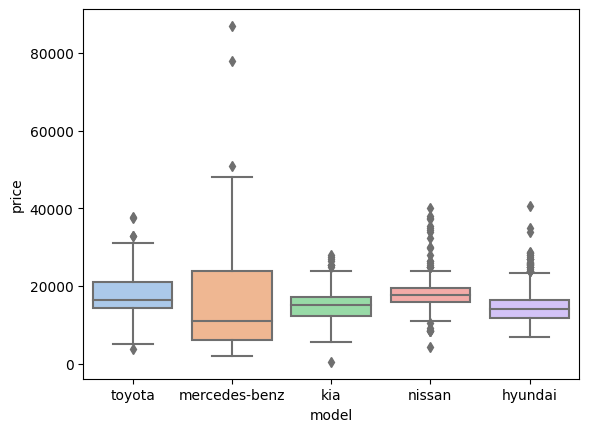

In [8]:
sns.boxplot(train,x='model', y='price', palette='pastel')

## Does the year impact the price?
There's an imbalance regarding the year of car models, which should be in the preprocessing step.

<Axes: xlabel='year', ylabel='price'>

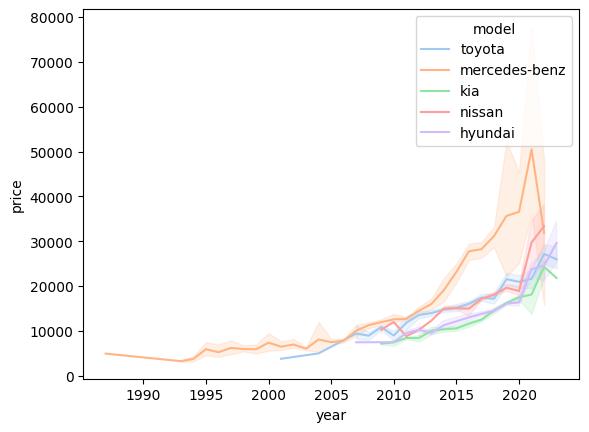

In [9]:
sns.lineplot(train, x='year', y='price', hue='model', palette='pastel')

## Car Type vs Price

<Axes: xlabel='type', ylabel='price'>

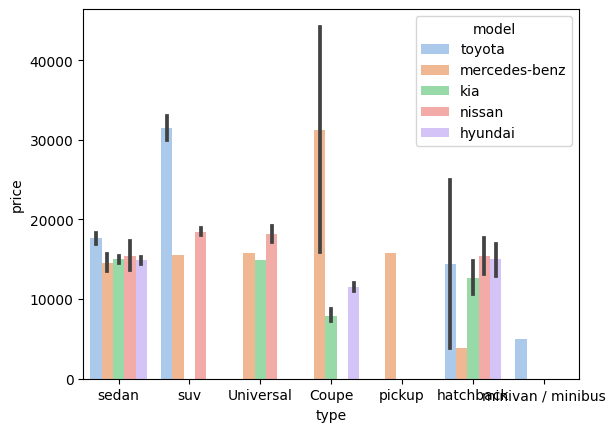

In [10]:
sns.barplot(train, x='type', y='price', hue='model', palette='pastel')

## Color vs Price

<Axes: xlabel='color', ylabel='price'>

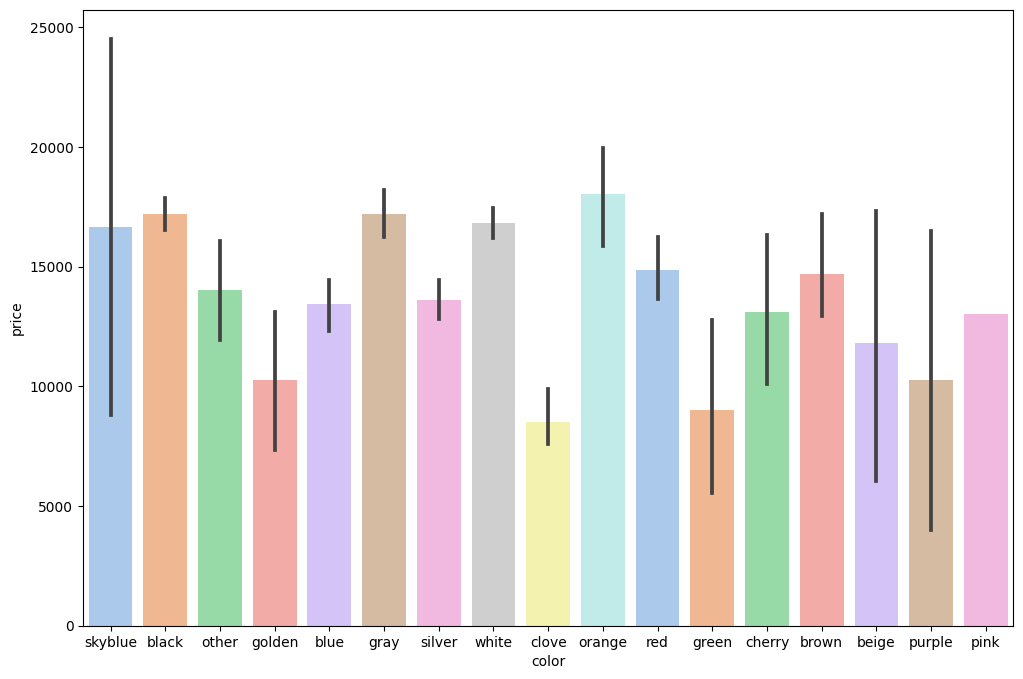

In [11]:
plt.figure(figsize=(12,8))
sns.barplot(train, x='color', y='price', palette='pastel')

## Motor Vol. vs Price

<Axes: xlabel='motor_volume', ylabel='price'>

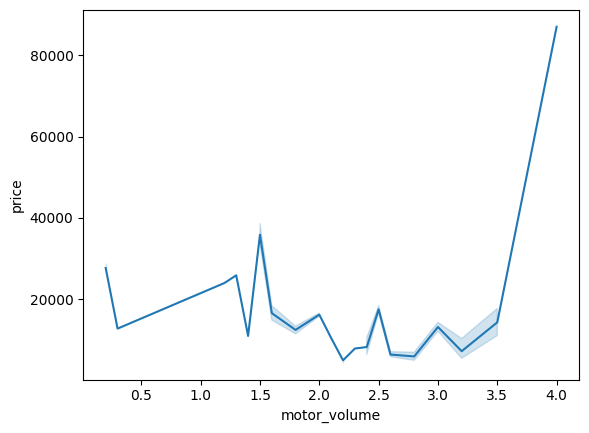

In [12]:
sns.lineplot(train, x='motor_volume', y='price')

Imbalance in wheel

In [13]:
all_data['wheel'].value_counts()

wheel
left     2051
right       2
Name: count, dtype: int64

# Data Preprocessing

- Remove Outliers
- Convert Running to Kilometers
- Convert Year to Age


## Remove Outliers

In [14]:
columns = ['price', 'year']
outlier_percentage = {}

for column in columns:
    column_data = train[column]

    Q1 = np.percentile(column_data, 25)
    Q3 = np.percentile(column_data, 75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = column_data[(column_data < lower) | (column_data > upper)]
    outlier_percentage[column] = len(outliers) / len(column_data) * 100

    print(f"Count of outliers in column '{column}': {len(outliers)}")
    print(f"Percentage of outliers in column '{column}':{len(outliers) / len(column_data) * 100:.2f}%")
    print()
    print(f"Lower : {lower}")
    print(f"Upper : {upper}")
    print()
    print(f"Data Outlier': {np.array(outliers)}")

Count of outliers in column 'price': 92
Percentage of outliers in column 'price':5.60%

Lower : 2250.0
Upper : 28250.0

Data Outlier': [30000 31000  2100 40000 48000 28700 29000 29000 40700 32000 35000 32500
 30000 29000 51000   462 31700 31000 34000 34000 28300 30000 87000 31500
 36000 33000 28900 33700 78000 33500 28500 32000 30000 37262 40000 29500
 31000 34000 33000 28700 33000 35000 35000 32700 37500 35500 32700 39500
 37500 36500 35500 28500 33000 30000 34900 37500 35000 33500 34500 33000
 29800 40000 35000 28500 37000 42000 37500 28486 29500 30000 39000 33600
 31000 30000 28500 35900 38000 28800 37800 35000 33000 31000 29900 35000
 32900 28500 40000 31000 35000 30000 32800 28500]
Count of outliers in column 'year': 159
Percentage of outliers in column 'year':9.68%

Lower : 2004.0
Upper : 2028.0

Data Outlier': [2002 2001 2002 1997 1998 2001 1999 1995 2001 2000 1996 1996 2001 1999
 2001 1993 2002 1997 1997 1998 2000 2001 1995 1995 2003 1997 1995 1998
 1996 1997 1998 2003 1998 199

In [15]:
def remove_outliers(df):
    column_list = ['price', 'year']

    for col in column_list:
        column_data = df[col]

        # Detect Outliers
        Q1 = np.percentile(column_data, 25)
        Q3 = np.percentile(column_data, 75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Remove Outlier
        df = df[(column_data >= lower) & (column_data <= upper)]

    return df

## Running to km

In [16]:
all_data['running'].apply(lambda x: float(x.split('  ')[0]) * 1.6 if x.split('  ')[1] == 'miles' else float(x.split('  ')[0]))

0        3000.0
1      132000.0
2      152000.0
3      219200.0
4      130000.0
         ...   
406     33400.0
407     96000.0
408    218000.0
409     64000.0
410    192000.0
Name: running, Length: 2053, dtype: float64

In [17]:
def convert_to_km(df):
    df['running_km'] = df['running'].apply(lambda x: float(x.split('  ')[0]) * 1.6 if x.split('  ')[1] == 'miles' else float(x.split('  ')[0]))
    return df.drop('running', axis=1)

## Convert Year to Age

In [18]:
all_data['year'].apply(lambda x: 2025 - x)

0       3
1      11
2       7
3      23
4       8
       ..
406     4
407     8
408    13
409     5
410     8
Name: year, Length: 2053, dtype: int64

In [19]:
def convert_to_age(df):
    df['age'] = df['year'].apply(lambda x: 2025 - x)
    return df.drop('year', axis=1)

# Pipeline

In [20]:
preprocess = all_data.copy()
preprocess.columns

Index(['model', 'year', 'motor_type', 'running', 'wheel', 'color', 'type',
       'status', 'motor_volume', 'price', 'IsTrain'],
      dtype='object')

In [21]:
columns_to_drop = ['wheel', 'price', 'IsTrain']
numerical_columns = ['age', 'running_km', 'motor_volume']
categorical_columns = ['model', 'color', 'type', 'motor_type']
ordinal_columns = ['status']

In [22]:
numerical_transformer = Pipeline(
    steps = [('StandardScaler', StandardScaler())]
)

categorical_transformer = Pipeline(
    steps = [('OneHotEncoder', OneHotEncoder(handle_unknown='ignore', sparse_output = False))]
)

ordinal_transformer = Pipeline(
    steps = [('OrdinalEncoder', OrdinalEncoder(categories=[['crashed', 'normal', 'good', 'excellent', 'new']]))]
)


preprocessor = ColumnTransformer(
    transformers=[
        ('column_dropper', 'drop', columns_to_drop),
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('ordinal', ordinal_transformer, ordinal_columns)
    ]
)

pipeline = Pipeline(
    steps=[
        ('convert_to_km', FunctionTransformer(convert_to_km)),
        ('convert_to_age', FunctionTransformer(convert_to_age)),
        ('preprocessing', preprocessor),
    ]
)

In [23]:
# Remove Outliers
preprocess_train = remove_outliers(preprocess[preprocess['IsTrain'] == 1])
preprocess_test = preprocess[preprocess['IsTrain'] == 0]

X = pipeline.fit_transform(preprocess_train)
y = np.log(preprocess_train['price']) # Normalize the price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_submission = pipeline.transform(preprocess_test)

<ipython-input-17-7d4747496015>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['running_km'] = df['running'].apply(lambda x: float(x.split('  ')[0]) * 1.6 if x.split('  ')[1] == 'miles' else float(x.split('  ')[0]))


# Fit & Parameter Tune Model

## Scikit-learn Models

In [24]:
models = {
    'SVR': SVR(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42),
    'LGBMRegressor': LGBMRegressor(force_row_wise=True, objective='regression', max_bin=255, random_state=42),
    'CatBoostRegressor': CatBoostRegressor(random_state=42)
}

param_grids = {
    'SVR': {
        'kernel': ['linear', 'rbf'],
        'C': [1e-2, 1e-1, 1],
        'gamma': [1e-3, 1e-2, 1e-1]
    },
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBRegressor': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 10],
        'learning_rate': [0.001, 0.01, 0.1]
    },
    'LGBMRegressor': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 10],
        'learning_rate': [0.001, 0.01, 0.1]
    },
    'CatBoostRegressor': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 10],
        'learning_rate': [0.001, 0.01, 0.1]
    }
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grids = {}
for model_name, model in models.items():
    grids[model_name] = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grids[model_name].fit(X_train, y_train)
    best_params = grids[model_name].best_params_
    best_score = grids[model_name].best_score_
    
    print(f'Best parameters for {model_name}: {best_params}')
    print(f'Best Score for {model_name}: {best_score}\n')

Best parameters for SVR: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score for SVR: -0.024957920364039272

Best parameters for RandomForest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best Score for RandomForest: -0.022764496231405397

Best parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Score for XGBRegressor: -0.02297511451471249

[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 1113, number of used features: 21
[LightGBM] [Info] Start training from score 9.634071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [25]:
def evaluate(model, model_name, X_test, y_test):
    print(f"Model: {model_name}")
    
    y_pred = model.predict(X_test)
    y_pred = np.e**(y_pred)
    y_test = np.e**(y_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"R-squared (R²): {r2:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}\n")
    
for model_name, model in grids.items():
    evaluate(model, model_name, X_test, y_test)

Model: SVR
R-squared (R²): 0.7038
Mean Squared Error (MSE): 6365389.4667
Mean Absolute Error (MAE): 1896.6996
Root Mean Squared Error (RMSE): 2522.9723

Model: RandomForest
R-squared (R²): 0.7482
Mean Squared Error (MSE): 5412271.9099
Mean Absolute Error (MAE): 1673.8290
Root Mean Squared Error (RMSE): 2326.4290

Model: XGBRegressor
R-squared (R²): 0.7043
Mean Squared Error (MSE): 6355805.2064
Mean Absolute Error (MAE): 1785.7212
Root Mean Squared Error (RMSE): 2521.0722

Model: LGBMRegressor
R-squared (R²): 0.7156
Mean Squared Error (MSE): 6113080.4459
Mean Absolute Error (MAE): 1765.1419
Root Mean Squared Error (RMSE): 2472.4644

Model: CatBoostRegressor
R-squared (R²): 0.7229
Mean Squared Error (MSE): 5954762.1076
Mean Absolute Error (MAE): 1745.6697
Root Mean Squared Error (RMSE): 2440.2381



### Ensemble

In [26]:
# All models
estimators = [
    ('SVR', grids['SVR'].best_estimator_),
    ('RandomForest', grids['RandomForest'].best_estimator_),
    ('XGBRegressor', grids['XGBRegressor'].best_estimator_),
    ('LGBMRegressor', grids['LGBMRegressor'].best_estimator_),
    ('CatBoostRegressor', grids['CatBoostRegressor'].best_estimator_)
]

all_voting_regressor = VotingRegressor(estimators=estimators, n_jobs=-1)
all_voting_regressor.fit(X_train, y_train)

all_stacking_regressor = StackingRegressor(estimators=estimators, n_jobs=-1)
all_stacking_regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('SVR', SVR(C=1, gamma=0.1)),
                              ('RandomForest',
                               RandomForestRegressor(max_depth=10,
                                                     min_samples_leaf=2,
                                                     min_samples_split=10,
                                                     n_estimators=200,
                                                     random_state=42)),
                              ('XGBRegressor',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('LGBMRegressor',
                               LGBMRegressor(force_row_wise=True, max_bin=255,
                                             max_depth=3,
                                             objective='regression',
                                             random_state=42)),
                              ('CatBoostRegressor',
                               <catboost.core.CatBoostRegressor object at 0x7d3555565300>)],
                  n_jobs=-1)

In [27]:
evaluate(all_voting_regressor, 'All Models Voting Regressor', X_test, y_test)
evaluate(all_stacking_regressor, 'All Models Stacking Regressor', X_test, y_test)

Model: All Models Voting Regressor
R-squared (R²): 0.7313
Mean Squared Error (MSE): 5775107.9266
Mean Absolute Error (MAE): 1731.1963
Root Mean Squared Error (RMSE): 2403.1454

Model: All Models Stacking Regressor
R-squared (R²): 0.7311
Mean Squared Error (MSE): 5779854.6752
Mean Absolute Error (MAE): 1726.3579
Root Mean Squared Error (RMSE): 2404.1328



In [28]:
# Top 3 best models
estimators = [
    ('RandomForest', grids['RandomForest'].best_estimator_),
    ('LGBMRegressor', grids['LGBMRegressor'].best_estimator_),
    ('CatBoostRegressor', grids['CatBoostRegressor'].best_estimator_)
]

top3_voting_regressor = VotingRegressor(estimators=estimators, n_jobs=-1)
top3_voting_regressor.fit(X_train, y_train)

top3_stacking_regressor = StackingRegressor(estimators=estimators, n_jobs=-1)
top3_stacking_regressor.fit(X_train, y_train)


StackingRegressor(estimators=[('RandomForest',
                               RandomForestRegressor(max_depth=10,
                                                     min_samples_leaf=2,
                                                     min_samples_split=10,
                                                     n_estimators=200,
                                                     random_state=42)),
                              ('LGBMRegressor',
                               LGBMRegressor(force_row_wise=True, max_bin=255,
                                             max_depth=3,
                                             objective='regression',
                                             random_state=42)),
                              ('CatBoostRegressor',
                               <catboost.core.CatBoostRegressor object at 0x7d3555565300>)],
                  n_jobs=-1)

In [29]:
evaluate(top3_voting_regressor, 'Voting Regressor', X_test, y_test)
evaluate(top3_stacking_regressor, 'Stacking Regressor', X_test, y_test)

Model: Voting Regressor
R-squared (R²): 0.7357
Mean Squared Error (MSE): 5679876.6154
Mean Absolute Error (MAE): 1705.0235
Root Mean Squared Error (RMSE): 2383.2492

Model: Stacking Regressor
R-squared (R²): 0.7366
Mean Squared Error (MSE): 5661223.0046
Mean Absolute Error (MAE): 1699.8689
Root Mean Squared Error (RMSE): 2379.3325



## YDF Model

YDF extends the power of TF-DF, offering new features, a simplified API, faster training times, updated documentation, and enhanced compatibility with popular ML libraries.

https://ydf.readthedocs.io/en/latest/

In [30]:
import ydf
print("Available Custom Models:\n" + '\n'.join([f"   •  {attr}" for attr in dir(ydf) if attr.endswith("Learner")]))

Available Custom Models:
   •  CartLearner
   •  DecisionTreeLearner
   •  DistributedGradientBoostedTreesLearner
   •  GenericLearner
   •  GradientBoostedTreesLearner
   •  IsolationForestLearner
   •  RandomForestLearner


In [31]:
processed_train = pd.concat([pd.DataFrame(X_train, columns=pipeline.named_steps['preprocessing'].get_feature_names_out()), pd.DataFrame(y_train, columns=['price']).reset_index(drop=True)], axis=1)
processed_test = pd.concat([pd.DataFrame(X_test, columns=pipeline.named_steps['preprocessing'].get_feature_names_out()), pd.DataFrame(y_test, columns=['price']).reset_index(drop=True)], axis=1)

In [32]:
tuner = ydf.RandomSearchTuner(num_trials=50)
tuner.choice("num_trees", [50, 100, 200, 300, 500, 1000])
tuner.choice("max_depth", [5, 10, 15, 20, 25, 30])
tuner.choice("growing_strategy", ['LOCAL', 'BEST_FIRST_GLOBAL'])
ydf_model = ydf.RandomForestLearner(label="price", 
                                    task=ydf.Task.REGRESSION, 
                                    tuner=tuner                                    
                                    ).train(processed_train)
ydf_model.describe()
evaluate(ydf_model, 'ydf', processed_test.drop('price', axis=1), processed_test['price'])

Train model on 1113 examples
Model trained in 0:00:36.469968
Model: ydf
R-squared (R²): 0.7507
Mean Squared Error (MSE): 5358070.9517
Mean Absolute Error (MAE): 1654.4900
Root Mean Squared Error (RMSE): 2314.7507



## Autogluon Model

AutoGluon is an open-source machine learning library that helps users build accurate models from data. It can process text, image, and tabular data. 

https://auto.gluon.ai/dev/tutorials/tabular/tabular-quick-start.html

In [33]:
from autogluon.tabular import TabularPredictor

autogluon_model = TabularPredictor(label='price', eval_metric='rmse')
autogluon_model.fit(processed_train,
              time_limit=600,
              presets='best_quality',
              num_bag_folds=5,
              num_bag_sets=5)

No path specified. Models will be saved in: "AutogluonModels/ag-20250222_143144"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       29.08 GB / 31.35 GB (92.8%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=5
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fi

In [34]:
autogluon_model.leaderboard(processed_test, silent=True)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesMSE_BAG_L2,-0.144191,-0.151312,root_mean_squared_error,3.313627,2.078408,271.835502,0.200938,0.169760,1.550037,2,True,14
1,LightGBMXT_BAG_L2,-0.145294,-0.149640,root_mean_squared_error,3.272687,2.036356,319.962645,0.159998,0.127708,49.677180,2,True,11
2,WeightedEnsemble_L3,-0.146158,-0.145106,root_mean_squared_error,3.541056,2.243270,274.768414,0.005072,0.003727,0.070907,3,True,15
3,LightGBM_BAG_L1,-0.146584,-0.149524,root_mean_squared_error,0.127688,0.142946,47.215984,0.127688,0.142946,47.215984,1,True,4
4,WeightedEnsemble_L2,-0.146608,-0.145112,root_mean_squared_error,2.184594,1.235565,231.687546,0.004260,0.001093,0.035303,2,True,10
5,CatBoost_BAG_L1,-0.146661,-0.145882,root_mean_squared_error,0.133643,0.202260,45.044184,0.133643,0.202260,45.044184,1,True,6
6,ExtraTreesMSE_BAG_L1,-0.147067,-0.158211,root_mean_squared_error,0.190964,0.161530,1.148614,0.190964,0.161530,1.148614,1,True,7
7,XGBoost_BAG_L1,-0.148034,-0.151187,root_mean_squared_error,0.457845,0.293915,35.748524,0.457845,0.293915,35.748524,1,True,9
8,LightGBM_BAG_L2,-0.148352,-0.150443,root_mean_squared_error,3.262275,2.084981,321.818388,0.149586,0.176333,51.532923,2,True,12
9,RandomForestMSE_BAG_L1,-0.149035,-0.158332,root_mean_squared_error,0.260660,0.203217,1.449064,0.260660,0.203217,1.449064,1,True,5


In [35]:
y_pred = autogluon_model.predict(processed_test, model='ExtraTreesMSE_BAG_L2')
y_pred = np.e**(y_pred)
y_test = np.e**(processed_test['price'])
    
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}\n")

2025-02-22 14:42:29,643	ERROR worker.py:422 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-02-22 14:42:29,652	ERROR worker.py:422 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-02-22 14:42:30,642	ERROR worker.py:422 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.


R-squared (R²): 0.7572
Mean Squared Error (MSE): 5217942.0264
Mean Absolute Error (MAE): 1630.0734
Root Mean Squared Error (RMSE): 2284.2815



# Submission

In [42]:
sample_submission = pd.read_csv('/kaggle/input/car-price-prediction-x/sample_submission.csv')
sample_submission.head()

,Id,price
0,0,38
1,1,20549
2,2,3927
3,3,5572
4,4,28598


In [46]:
X_submission = pd.DataFrame(X_submission, columns=pipeline.named_steps['preprocessing'].get_feature_names_out())
X_submission['price'] = np.nan
y_submission = autogluon_model.predict(X_submission, model='ExtraTreesMSE_BAG_L2')
y_submission = np.e**y_submission
submission_df = pd.concat([sample_submission['Id'], y_submission], axis=1)

submission_df.to_csv('submission.csv', index=False)